In [44]:
import numpy
#modified from http://www.quuxlabs.com/blog/2010/09/matrix-factorization-a-simple-tutorial-and-implementation-in-python/
def matrix_factorization(R,P,Q,K,steps=20000,alpha=0.0002,beta=0.02):
    Q=Q.T
    for step in range(steps):
        for i in range(len(R)):
            for j in range(len(R[i])):
                if R[i][j]>-1:
                    eij=R[i][j]-numpy.dot(P[i,:],Q[:,j])
                    for k in range(K):
                        P[i][k]=P[i][k]+alpha*(2*eij*Q[k][j]-beta*P[i][k])
                        Q[k][j]=Q[k][j]+alpha*(2*eij*P[i][k]-beta*Q[k][j])        
        e=0
        for i in range(len(R)):
            for j in range(len(R[i])):
                if R[i][j]>0:
                    e=e+pow(R[i][j]-numpy.dot(P[i,:],Q[:,j]),2)
                    for k in range(K):
                        e=e+(beta/2)*(pow(P[i][k],2)+pow(Q[k][j],2))
        if e < 0.001:
            break
    return P,Q.T

R=[
    [0,1,-1],
    [1,-1,1],
    [-1,1,2],
]

    
R=numpy.array(R)    
N=len(R)
M=len(R[0])
K=1
P=numpy.random.rand(N,K)
Q=numpy.random.rand(M,K)

nP,nQ=matrix_factorization(R,P,Q,K)
nR=numpy.dot(nP,nQ.T)    
    
    
print("qns 1")
print("A")
print(nR)
print("\nU")
print(nP)
print("\nV")
print(nQ)


qns 1
A
[[0.47910037 0.58272018 0.91052806]
 [0.62383311 0.75875571 1.18559197]
 [0.97877222 1.19046104 1.86015212]]

U
[[0.67777808]
 [0.88252991]
 [1.38465839]]

V
[[0.70686909]
 [0.85975071]
 [1.34340147]]


Initial classification


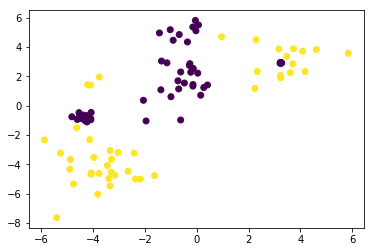

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
csv="https://www.dropbox.com/s/wt45tvn9ig3o7vu/kernel.csv?dl=1"
data=np.genfromtxt(csv,delimiter=",")
X=data[:,1:]
Y=data[:,0]
plt.scatter(X[:,0],X[:,1],c=Y)
print("Initial classification")
plt.show()

In [5]:
print("qns2a")
#gamma=0.5
#K(x,xi)=exp(-gamma*sum(x-xi^2))

from sklearn import svm


#create svm classifier based on RBF kernel
clf=svm.SVC(kernel='rbf',gamma=0.5)

#train the model using training sets
clf.fit(X,Y)

qns2a


qns2b
qns2c


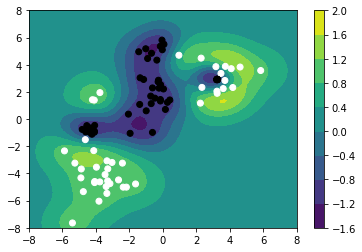

In [6]:
print("qns2b")
def decision(x1,x2,clf):
    x=np.array([[x1,x2]])
    value=clf.decision_function(x)
    return value

print("qns2c")
vdecision=np.vectorize(decision,excluded=[2])
x1list=np.linspace(-8.0,8.0,100)
x2list=np.linspace(-8.0,8.0,100)
X1,X2=np.meshgrid(x1list,x2list)
Z=vdecision(X1,X2,clf)
cp=plt.contourf(X1,X2,Z)
plt.colorbar(cp)
plt.scatter(X[:,0],X[:,1],c=Y,cmap="gray")
plt.show()


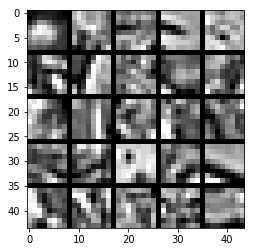

In [10]:
%matplotlib inline
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
from scipy.optimize import fmin_l_bfgs_b as minimize

from utils import normalize,tile_raster_images,sigmoid
from utils import ravelParameters,unravelParameters
from utils import initializeParameters
from utils import computeNumericalGradient

nV=8*8 #no of visible units
nH=25 # no of hidden units
dW=0.0001 # weight decay term
sW=3

npy="images.npy"
X=normalize(np.load(npy))
plt.imshow(tile_raster_images(X=X,img_shape=(8,8),tile_shape=(5,5),tile_spacing=(1,1)),cmap="gray")
plt.show()

In [34]:
print("qns3a")
def spareseAutoencoderCost(theta,nV,nH,dW,sW,X):
    W1,W2,b1,b2=unravelParameters(theta,nH,nV)
    n=X.shape[0]
    z2=np.dot(X,W1)+np.dot(np.ones((n,1)),b1.T)
    a2=sigmoid(z2)
    z3=np.dot(a2,W2)+np.dot(np.ones((n,1)),b2.T)
    a3=sigmoid(z3)
    eps=a3-X
    loss=(norm(eps)**2) / (2*n)
    decay=((norm(W1)**2)+(norm(W2)**2))/2
    
    #Compute sparsity terms and total cost
    rho=0.01
    a2mean=np.mean(a2,axis=0).reshape(nH,1)
    kl=np.sum(rho*np.log(rho/a2mean)+(1-rho)*np.log((1-rho)/(1-a2mean)))
    dkl=-rho/a2mean+(1-rho)/(1-a2mean)
    cost=loss+dW*decay+sW*kl        #beta:sW , lambda:dW
    d3=eps*a3*(1-a3)
    d2=(sW*dkl.T+np.dot(d3,W2.T))*a2*(1-a2)
    W1grad=(np.dot(X.T,d2)/n)+(dW*W1)
    W2grad=(np.dot(a2.T,d3)/n)+(dW*W2)
    b1grad=np.dot(d2.T,np.ones((n,1)))/n
    b2grad=np.dot(d3.T,np.ones((n,1)))/n
    grad=ravelParameters(W1grad,W2grad,b1grad,b2grad)
    print(" .",end="")
    return cost,grad

theta=initializeParameters(nH,nV)
cost,grad=spareseAutoencoderCost(theta,nV,nH,dW,sW,X)
print(theta)
print(cost)
print(grad)

qns3a
 .[-0.23305909  0.16533535 -0.11291014 ...  0.          0.
  0.        ]
45.286110403739876
[ 0.76295401  0.79391605  0.78156155 ... -0.00162212 -0.02906836
  0.03348396]


In [36]:
print("qns3b")
print("\nComparing numerical gradient with backprop gradient")
num_coords=5
indices=np.random.choice(theta.size,num_coords,replace=False)
numgrad=computeNumericalGradient(lambda t:spareseAutoencoderCost(t,nV,nH,dW,sW,X)[0],theta,indices)
subnumgrad=numgrad[indices]
subgrad=grad[indices]
diff=norm(subnumgrad-subgrad)/norm(subnumgrad+subgrad)
print("\n",np.array([subnumgrad,subgrad]).T)
print("The relative difference is",diff)


qns3b

Comparing numerical gradient with backprop gradient
 .

 . .

 . .

 . .

 . .

 .
 [[ 0.00650636  0.00650636]
 [ 0.74735546  0.74735546]
 [ 0.01583072  0.01583072]
 [ 0.72690943  0.72690943]
 [-0.01064557 -0.01064557]]
The relative difference is 8.840651519954456e-11


qns3c

Training neural network
 .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 .

 . .

 . .

 . .

 .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . . .

 .

 . . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

 . .

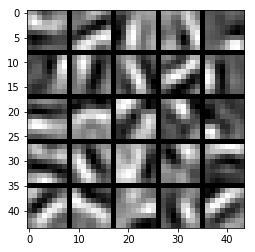

In [37]:
print("qns3c")
print("\nTraining neural network")
theta=initializeParameters(nH,nV)
opttheta,cost,messages=minimize(spareseAutoencoderCost,theta,fprime=None,maxiter=400,args=(nV,nH,dW,sW,X))
W1,W2,b1,b2=unravelParameters(opttheta,nH,nV)
plt.imshow(tile_raster_images(X=W1.T,img_shape=(8,8),tile_shape=(5,5),tile_spacing=(1,1)),cmap="gray")
plt.show()



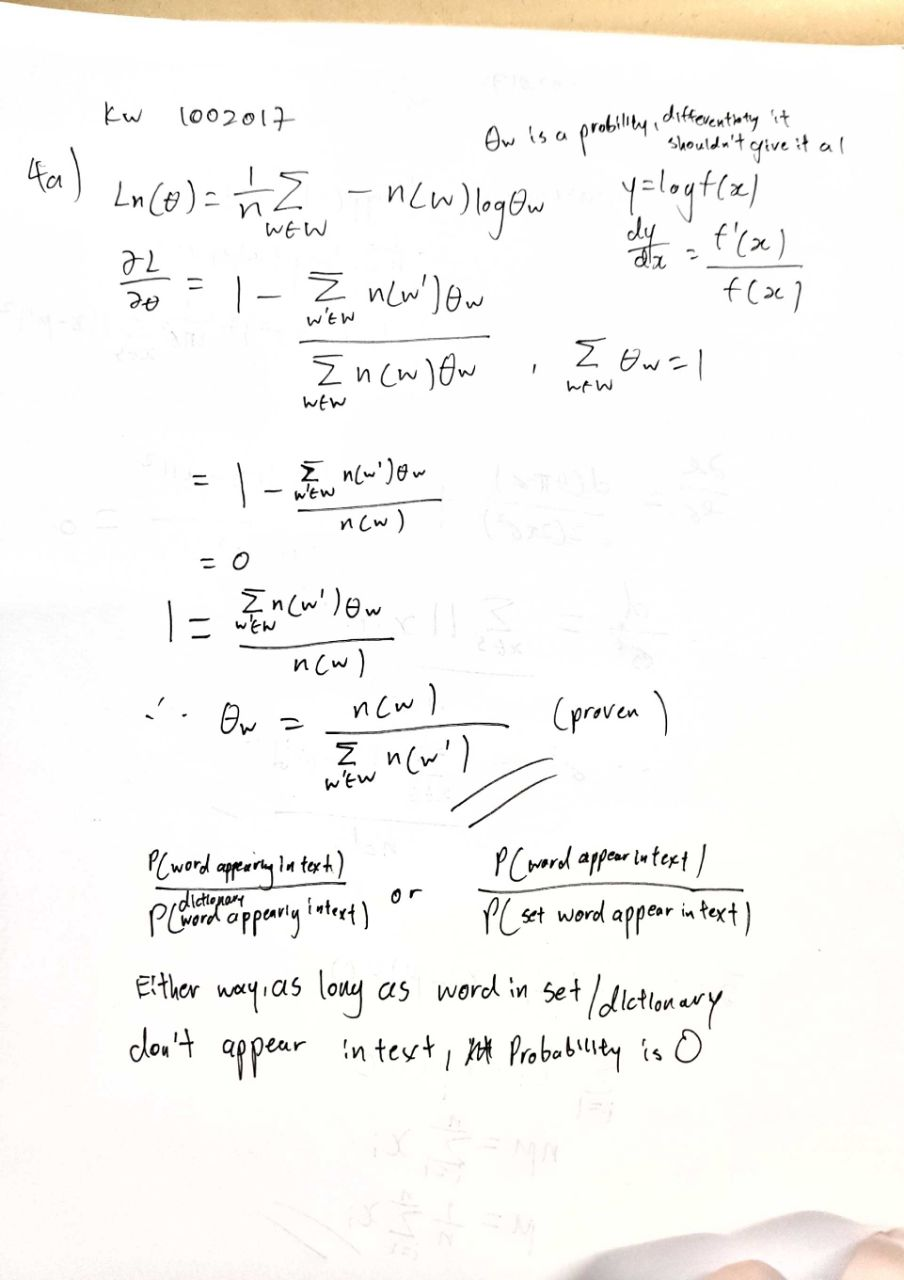

In [42]:
from IPython.display import Image
Image(filename="4a.jpg")

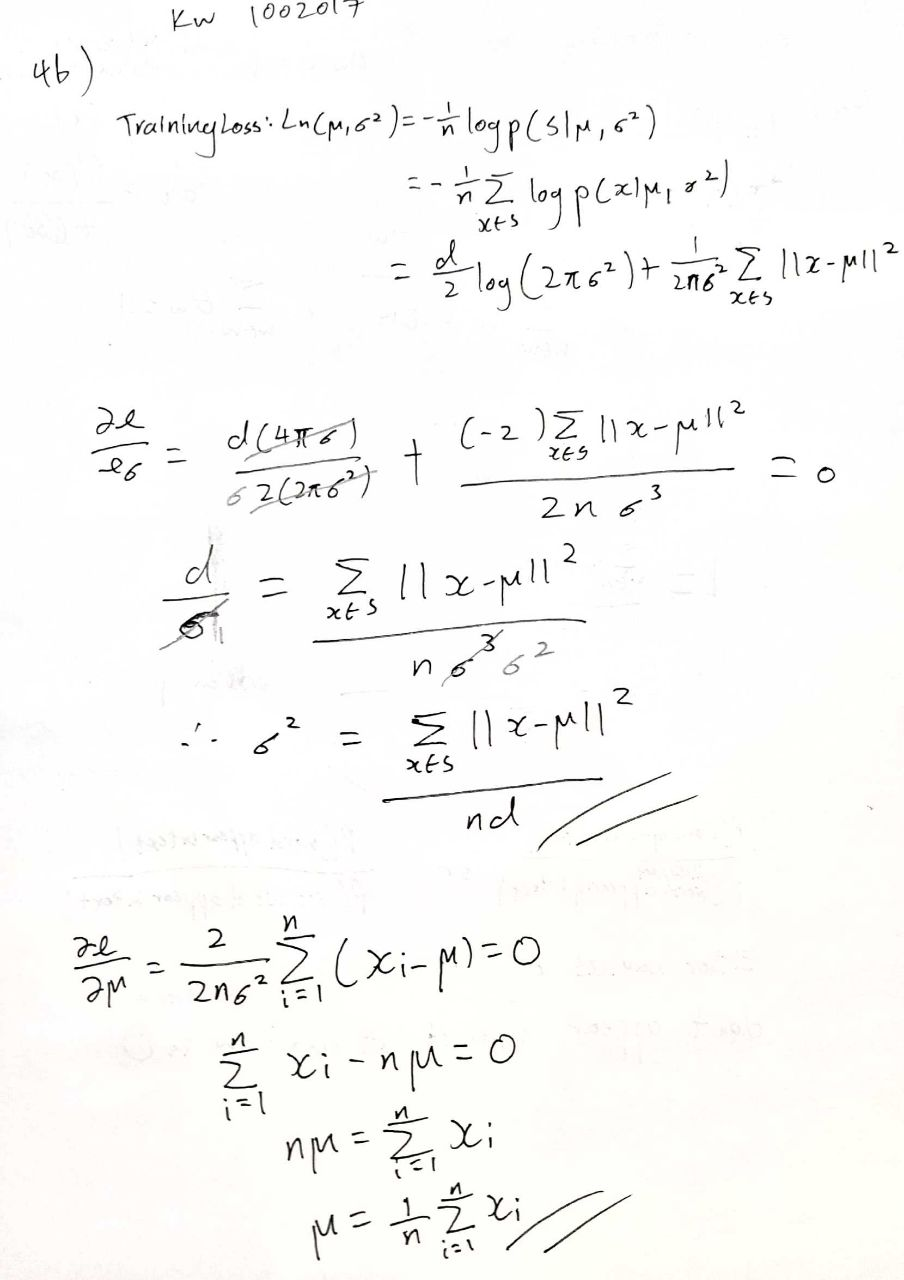

In [43]:
from IPython.display import Image
Image(filename="4b.jpg")